## 보험 사기 사고 예측

### 라이브러리 호출

In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import sklearn; sklearn.show_versions()
from sklearn.svm import SVC

import pandas
import sklearn
import imblearn

import warnings
warnings.filterwarnings( 'ignore' )

print(pandas.__version__)
print(sklearn.__version__)
print(imblearn.__version__)


System:
    python: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46)  [GCC 9.4.0]
executable: /opt/conda/bin/python
   machine: Linux-5.15.107+-x86_64-with-glibc2.31

Python dependencies:
          pip: 21.3.1
   setuptools: 59.4.0
      sklearn: 1.0
        numpy: 1.21.4
        scipy: 1.7.1
       Cython: 0.29.24
       pandas: 1.3.3
   matplotlib: 3.4.3
       joblib: 1.1.0
threadpoolctl: 3.0.0

Built with OpenMP: True
1.3.3
1.0
0.8.1


### 데이터 로드 및 확인

In [2]:
# 데이터셋을 준비합니다.
df = pd.read_csv(os.getenv('HOME')+'/data.csv')

In [1]:
#활용할 피쳐와 레이블 
features = df.columns.drop([ 'test/train/unlabeled', 'isfraud'])
label = ['isfraud'] 

(array([351.,   0.,   0.,   0.,   0., 191.,   0.,   0.,   0.,  58.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

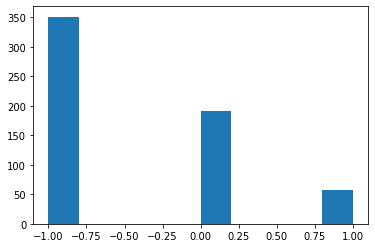

In [6]:
# 레이블 분포 확인
plt.hist(df['isfraud'])

 -1은 레이블이 없는 데이터, 0은 일반사고, 1은 보험사기 사고를 의미  
 상당수는 레이블이 없는 데이터임을 확인할 수 있다.

### 성능 비교를 위한 베이스라인 모델

In [7]:
# 트레인 셋 / 테스트 셋 
X_train_labeled = df[df['test/train/unlabeled']==2][features]
Y_train_labeled = df[df['test/train/unlabeled']==2][label]

X_test_labeled = df[df['test/train/unlabeled']==1][features]
Y_test_labeled = df[df['test/train/unlabeled']==1][label]

In [8]:
clf1 = LogisticRegression(random_state=0).fit(X_train_labeled, Y_train_labeled.values.ravel())

# 결과 확인
y = Y_test_labeled
y_pred = clf1.predict(X_test_labeled)

              precision    recall  f1-score   support

           0       0.92      0.71      0.80       124
           1       0.32      0.68      0.44        25

    accuracy                           0.70       149
   macro avg       0.62      0.69      0.62       149
weighted avg       0.82      0.70      0.74       149



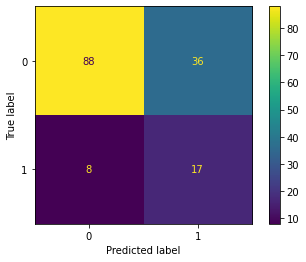

In [9]:
# 평가 
print(classification_report(y, y_pred))
ConfusionMatrixDisplay.from_estimator(clf1, X_test_labeled, Y_test_labeled)  
plt.show()  

# 보험사기건에 대한 f1-score 0.44를 기록했습니다.

In [10]:
baseline_report = classification_report(y, y_pred)

### 실험

1. sklearn.semi_supervised.LabelSpreading 을 활용해서 unlabeled 데이터에 label을 할당한다.
    - knn 모델을 활용하며, k는 각각 1, 3, 5로 실험을 진행  
    
    
2. unlabeled 데이터는 전체 데이터를 활용하지 않고, 일부만을 활용해 본다.
    - 10%, 30%, 50%를 샘플링해서 실험

#### ■ k = 1, sample = 10%

In [11]:
# 레이블이 있는 train set과 레이블이 없는 train set 나누기
X_train_labeled = df[df['test/train/unlabeled'] == 2][features]
Y_train_labeled = df[df['test/train/unlabeled'] == 2][label]

X_train_unlabeled = df[df['test/train/unlabeled'] == 3][features]
Y_train_unlabeled = df[df['test/train/unlabeled'] == 3][label]

In [12]:
X_train_labeled.shape, Y_train_labeled.shape, X_train_unlabeled.shape, Y_train_unlabeled.shape

((100, 50), (100, 1), (351, 50), (351, 1))

In [13]:
Y_train_labeled.value_counts()

isfraud
0          67
1          33
dtype: int64

In [14]:
# unlabeled 데이터 중 10%만 샘플링
sample_frac = 0.1
num_samples = int(len(X_train_unlabeled) * sample_frac)

# 데이터를 샘플링할 무작위 인덱스 생성
random_indices = np.random.choice(len(X_train_unlabeled), num_samples)

# 샘플링된 데이터 가져오기
X_train_unlabeled_sampled = X_train_unlabeled.iloc[random_indices]
Y_train_unlabeled_sampled = Y_train_unlabeled.iloc[random_indices]
print(X_train_unlabeled_sampled.shape, Y_train_unlabeled_sampled.shape)


(35, 50) (35, 1)


In [15]:
# 샘플링된 레이블이 없는 데이터와 레이블이 있는 데이터를 합치기
X_train_combined = pd.concat([X_train_labeled, X_train_unlabeled_sampled], axis=0)
Y_train_combined = pd.concat([Y_train_labeled, Y_train_unlabeled_sampled], axis=0)

print(X_train_combined.shape, Y_train_combined.shape)

(135, 50) (135, 1)


In [16]:
Y_train_combined.value_counts()

isfraud
 0         67
-1         35
 1         33
dtype: int64

In [17]:
# 남은 unlabeled 데이터 중 len(X_train_combined)만큼 추출하여 테스트 데이터로 만들기
remaining_indices = [idx for idx in range(len(X_train_unlabeled)) if idx not in random_indices]
X_test_unlabeled = X_train_unlabeled.iloc[remaining_indices][:X_train_combined.shape[0]]
Y_test_unlabeled = Y_train_unlabeled.iloc[remaining_indices][:X_train_combined.shape[0]]
X_test_unlabeled.shape, Y_test_unlabeled.shape

((135, 50), (135, 1))

In [18]:
# 모델 선언 (k = 1)
label_prop_model = LabelSpreading(kernel='knn', n_neighbors=1)

# 학습 및 예측
label_prop_model.fit(X_train_combined, Y_train_combined)
y_pred = label_prop_model.predict(X_test_unlabeled)

# 성능 평가
report = classification_report(Y_train_combined, y_pred)
print(report)

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00        35
           0       0.54      0.82      0.65        67
           1       0.39      0.39      0.39        33

    accuracy                           0.50       135
   macro avg       0.31      0.40      0.35       135
weighted avg       0.36      0.50      0.42       135



#### ■ k = 1, sample = 30%

In [19]:
def semi_supervised_learning(k, sample_frac):
    # 레이블이 있는 train set과 레이블이 없는 train set 나누기
    X_train_labeled = df[df['test/train/unlabeled'] == 2][features]
    Y_train_labeled = df[df['test/train/unlabeled'] == 2][label]

    X_train_unlabeled = df[df['test/train/unlabeled'] == 3][features]
    Y_train_unlabeled = df[df['test/train/unlabeled'] == 3][label]
    print('레이블 있는 데이터와 없는 데이터 shape')
    print(X_train_labeled.shape, Y_train_labeled.shape, X_train_unlabeled.shape, Y_train_unlabeled.shape)
    print('-'*70)
    
    # unlabeled 데이터 중 일부만 샘플링
    sample_size = int(len(X_train_unlabeled) * sample_frac)
    # 데이터를 샘플링할 무작위 인덱스 생성
    random_indices = np.random.choice(len(X_train_unlabeled), sample_size, replace=False)
    # 샘플링된 데이터
    X_train_unlabeled_sampled = X_train_unlabeled.iloc[random_indices]
    Y_train_unlabeled_sampled = Y_train_unlabeled.iloc[random_indices]
    print('샘플링된 데이터 shape')
    print(X_train_unlabeled_sampled.shape, Y_train_unlabeled_sampled.shape)
    print('-'*70)

    # 샘플링된 레이블이 없는 데이터와 레이블이 있는 데이터를 합치기
    X_train_combined = pd.concat([X_train_labeled, X_train_unlabeled_sampled], axis=0)
    Y_train_combined = pd.concat([Y_train_labeled, Y_train_unlabeled_sampled], axis=0)
    print('레이블 있는 데이터와 없는 데이터 합친 데이터 shape')
    print(X_train_combined.shape, Y_train_combined.shape)
    print('-'*70)
    
    # 남은 unlabeled 데이터 중 샘플링된 데이터와 같은 수만큼 추출하여 테스트 데이터로 만들기
    remaining_indices = [idx for idx in range(len(X_train_unlabeled)) if idx not in random_indices]
    X_test_unlabeled = X_train_unlabeled.iloc[remaining_indices][:len(X_train_combined)]
    Y_test_unlabeled = Y_train_unlabeled.iloc[remaining_indices][:len(X_train_combined)]
    print('테스트 데이터 shape')
    print(X_test_unlabeled.shape, Y_test_unlabeled.shape)
    print('-'*70)

    # 모델 선언 (k 지정)
    label_prop_model = LabelSpreading(kernel='knn', n_neighbors=k)

    # 학습 및 예측
    label_prop_model.fit(X_train_combined, Y_train_combined)
    y_pred = label_prop_model.predict(X_test_unlabeled)

    # 성능 평가
    report = classification_report(Y_train_combined, y_pred)
    return report

기존에는 위의 코드처럼 구현을 했는데, test 데이터를 생성하는 부분에서 데이터 수가 맞지 않아서 샘플링 비율을 50%로 조정했을 때, 에러가 났다. 이유는 np.random.choice를 할때, replace = False로 설정해서 데이터 중복을 막게 되어 데이터 수가 부족했던 것이었다. 그래서 해당 옵션을 그냥 없앤 코드로 10% 샘플링 코드부터 다시 구현했다.

In [23]:
def semi_supervised_learning(k, sample_frac):
    # 레이블이 있는 train set과 레이블이 없는 train set 나누기
    X_train_labeled = df[df['test/train/unlabeled'] == 2][features]
    Y_train_labeled = df[df['test/train/unlabeled'] == 2][label]

    X_train_unlabeled = df[df['test/train/unlabeled'] == 3][features]
    Y_train_unlabeled = df[df['test/train/unlabeled'] == 3][label]
    print('레이블 있는 데이터와 없는 데이터 shape')
    print(X_train_labeled.shape, Y_train_labeled.shape, X_train_unlabeled.shape, Y_train_unlabeled.shape)
    print('-'*70)
    
    # unlabeled 데이터 중 일부만 샘플링
    sample_size = int(len(X_train_unlabeled) * sample_frac)
    # 데이터를 샘플링할 무작위 인덱스 생성
    random_indices = np.random.choice(len(X_train_unlabeled), sample_size)
    # 샘플링된 데이터
    X_train_unlabeled_sampled = X_train_unlabeled.iloc[random_indices]
    Y_train_unlabeled_sampled = Y_train_unlabeled.iloc[random_indices]
    print('샘플링된 데이터 shape')
    print(X_train_unlabeled_sampled.shape, Y_train_unlabeled_sampled.shape)
    print('-'*70)

    # 샘플링된 레이블이 없는 데이터와 레이블이 있는 데이터를 합치기
    X_train_combined = pd.concat([X_train_labeled, X_train_unlabeled_sampled], axis=0)
    Y_train_combined = pd.concat([Y_train_labeled, Y_train_unlabeled_sampled], axis=0)
    print('레이블 있는 데이터와 없는 데이터 합친 데이터 shape')
    print(X_train_combined.shape, Y_train_combined.shape)
    print('-'*70)
    
    # 남은 unlabeled 데이터 중 학습 데이터와 같은 크기로 테스트 데이터 생성
    remaining_indices = [idx for idx in range(len(X_train_unlabeled)) if idx not in random_indices]
    num_test_samples = len(X_train_combined)
    random_test_indices = np.random.choice(remaining_indices, num_test_samples)
    X_test_unlabeled = X_train_unlabeled.iloc[random_test_indices]
    Y_test_unlabeled = Y_train_unlabeled.iloc[random_test_indices]
    print('테스트 데이터 shape')
    print(X_test_unlabeled.shape, Y_test_unlabeled.shape)
    print('-'*70)

    # 모델 선언 (k 지정)
    label_prop_model = LabelSpreading(kernel='knn', n_neighbors=k)

    # 학습 및 예측
    label_prop_model.fit(X_train_combined, Y_train_combined)
    y_pred = label_prop_model.predict(X_test_unlabeled)

    # 성능 평가
    report = classification_report(Y_train_combined, y_pred)
    return report

In [24]:
report_1_30 = semi_supervised_learning(k=1, sample_frac=0.3)
print("K=1, 30% 샘플링 결과:\n", report_1_30)

레이블 있는 데이터와 없는 데이터 shape
(100, 50) (100, 1) (351, 50) (351, 1)
----------------------------------------------------------------------
샘플링된 데이터 shape
(105, 50) (105, 1)
----------------------------------------------------------------------
레이블 있는 데이터와 없는 데이터 합친 데이터 shape
(205, 50) (205, 1)
----------------------------------------------------------------------
테스트 데이터 shape
(205, 50) (205, 1)
----------------------------------------------------------------------
K=1, 30% 샘플링 결과:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       105
           0       0.33      0.82      0.47        67
           1       0.20      0.24      0.22        33

    accuracy                           0.31       205
   macro avg       0.18      0.35      0.23       205
weighted avg       0.14      0.31      0.19       205



#### ■ k = 1, sample = 50%

In [22]:
report_1_50 = semi_supervised_learning(k=1, sample_frac=0.5)
print("K=1, 50% 샘플링 결과:\n", report_1_50)

레이블 있는 데이터와 없는 데이터 shape
(100, 50) (100, 1) (351, 50) (351, 1)
----------------------------------------------------------------------
샘플링된 데이터 shape
(175, 50) (175, 1)
----------------------------------------------------------------------
레이블 있는 데이터와 없는 데이터 합친 데이터 shape
(275, 50) (275, 1)
----------------------------------------------------------------------
테스트 데이터 shape
(176, 50) (176, 1)
----------------------------------------------------------------------


ValueError: Found input variables with inconsistent numbers of samples: [275, 176]

In [25]:
report_1_50 = semi_supervised_learning(k=1, sample_frac=0.5)
print("K=1, 50% 샘플링 결과:\n", report_1_50)

레이블 있는 데이터와 없는 데이터 shape
(100, 50) (100, 1) (351, 50) (351, 1)
----------------------------------------------------------------------
샘플링된 데이터 shape
(175, 50) (175, 1)
----------------------------------------------------------------------
레이블 있는 데이터와 없는 데이터 합친 데이터 shape
(275, 50) (275, 1)
----------------------------------------------------------------------
테스트 데이터 shape
(275, 50) (275, 1)
----------------------------------------------------------------------
K=1, 50% 샘플링 결과:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       175
           0       0.23      0.82      0.36        67
           1       0.09      0.09      0.09        33

    accuracy                           0.21       275
   macro avg       0.10      0.30      0.15       275
weighted avg       0.07      0.21      0.10       275



#### ■ k = 3, sample = 10%

In [26]:
report_3_10 = semi_supervised_learning(k=3, sample_frac=0.1)
print("K=3, 10% 샘플링 결과:\n", report_3_10)

레이블 있는 데이터와 없는 데이터 shape
(100, 50) (100, 1) (351, 50) (351, 1)
----------------------------------------------------------------------
샘플링된 데이터 shape
(35, 50) (35, 1)
----------------------------------------------------------------------
레이블 있는 데이터와 없는 데이터 합친 데이터 shape
(135, 50) (135, 1)
----------------------------------------------------------------------
테스트 데이터 shape
(135, 50) (135, 1)
----------------------------------------------------------------------
K=3, 10% 샘플링 결과:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00        35
           0       0.53      0.84      0.65        67
           1       0.40      0.36      0.38        33

    accuracy                           0.50       135
   macro avg       0.31      0.40      0.34       135
weighted avg       0.36      0.50      0.42       135



#### ■ k = 3, sample = 30%

In [27]:
report_3_30 = semi_supervised_learning(k=3, sample_frac=0.3)
print("K=3, 30% 샘플링 결과:\n", report_3_30)

레이블 있는 데이터와 없는 데이터 shape
(100, 50) (100, 1) (351, 50) (351, 1)
----------------------------------------------------------------------
샘플링된 데이터 shape
(105, 50) (105, 1)
----------------------------------------------------------------------
레이블 있는 데이터와 없는 데이터 합친 데이터 shape
(205, 50) (205, 1)
----------------------------------------------------------------------
테스트 데이터 shape
(205, 50) (205, 1)
----------------------------------------------------------------------
K=3, 30% 샘플링 결과:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       105
           0       0.34      0.72      0.46        67
           1       0.13      0.24      0.17        33

    accuracy                           0.27       205
   macro avg       0.15      0.32      0.21       205
weighted avg       0.13      0.27      0.18       205



#### ■ k = 3, sample = 50%

In [28]:
report_3_50 = semi_supervised_learning(k=3, sample_frac=0.5)
print("K=3, 50% 샘플링 결과:\n", report_3_50)

레이블 있는 데이터와 없는 데이터 shape
(100, 50) (100, 1) (351, 50) (351, 1)
----------------------------------------------------------------------
샘플링된 데이터 shape
(175, 50) (175, 1)
----------------------------------------------------------------------
레이블 있는 데이터와 없는 데이터 합친 데이터 shape
(275, 50) (275, 1)
----------------------------------------------------------------------
테스트 데이터 shape
(275, 50) (275, 1)
----------------------------------------------------------------------
K=3, 50% 샘플링 결과:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       175
           0       0.24      0.76      0.37        67
           1       0.08      0.15      0.10        33

    accuracy                           0.20       275
   macro avg       0.11      0.30      0.16       275
weighted avg       0.07      0.20      0.10       275



#### ■ k = 5, sample = 10%

In [29]:
report_5_10 = semi_supervised_learning(k=5, sample_frac=0.1)
print("K=5, 10% 샘플링 결과:\n", report_5_10)

레이블 있는 데이터와 없는 데이터 shape
(100, 50) (100, 1) (351, 50) (351, 1)
----------------------------------------------------------------------
샘플링된 데이터 shape
(35, 50) (35, 1)
----------------------------------------------------------------------
레이블 있는 데이터와 없는 데이터 합친 데이터 shape
(135, 50) (135, 1)
----------------------------------------------------------------------
테스트 데이터 shape
(135, 50) (135, 1)
----------------------------------------------------------------------
K=5, 10% 샘플링 결과:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00        35
           0       0.50      0.85      0.63        67
           1       0.30      0.18      0.23        33

    accuracy                           0.47       135
   macro avg       0.27      0.34      0.28       135
weighted avg       0.32      0.47      0.37       135



#### ■ k = 5, sample = 30%

In [30]:
report_5_30 = semi_supervised_learning(k=5, sample_frac=0.3)
print("K=5, 30% 샘플링 결과:\n", report_5_30)

레이블 있는 데이터와 없는 데이터 shape
(100, 50) (100, 1) (351, 50) (351, 1)
----------------------------------------------------------------------
샘플링된 데이터 shape
(105, 50) (105, 1)
----------------------------------------------------------------------
레이블 있는 데이터와 없는 데이터 합친 데이터 shape
(205, 50) (205, 1)
----------------------------------------------------------------------
테스트 데이터 shape
(205, 50) (205, 1)
----------------------------------------------------------------------
K=5, 30% 샘플링 결과:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       105
           0       0.32      0.76      0.45        67
           1       0.13      0.18      0.15        33

    accuracy                           0.28       205
   macro avg       0.15      0.31      0.20       205
weighted avg       0.13      0.28      0.17       205



#### ■ k = 5, sample = 50%

In [31]:
report_5_50 = semi_supervised_learning(k=5, sample_frac=0.5)
print("K=5, 50% 샘플링 결과:\n", report_5_50)

레이블 있는 데이터와 없는 데이터 shape
(100, 50) (100, 1) (351, 50) (351, 1)
----------------------------------------------------------------------
샘플링된 데이터 shape
(175, 50) (175, 1)
----------------------------------------------------------------------
레이블 있는 데이터와 없는 데이터 합친 데이터 shape
(275, 50) (275, 1)
----------------------------------------------------------------------
테스트 데이터 shape
(275, 50) (275, 1)
----------------------------------------------------------------------
K=5, 50% 샘플링 결과:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00       175
           0       0.27      0.81      0.41        67
           1       0.13      0.30      0.18        33

    accuracy                           0.23       275
   macro avg       0.13      0.37      0.20       275
weighted avg       0.08      0.23      0.12       275



- __베이스라인의 모델 성능__
    - 모델의 정확도는 대략 0.70이다.
    - 일반사고에 대한 정밀도는 높지만 보험사기사고에 대한 정밀도는 낮다.
    - 일반사고에 대한 재현율이 조금 더 높다.
    - 일반사고에 대한 f1-score가 높다.



- __Semi-supervised learning 모델 성능__
    - 일반적으로 베이스라인 모델보다 성능이 낮다.
    - unlabeled 데이터를 사용해서 낮은 것 같다..



- __9가지 실험 해석__
    - K 값이 증가할수록, semi-supervised learning 모델의 성능이 향상되는 경향이 있다.
    - labeled percentage(레이블이 있는 비율)이 낮을수록 semi-supervised learning 모델의 성능이 하락하는 경향이 있다.
    - 특히, 0.1 비율에서 모델의 성능이 매우 낮다.

## 회고

### 어려웠던 점 / 느낀점
> - 이번 프로젝트는 준지도학습 기법을 사용하여 데이터를 예측하는 것이었다. 노드에서 예시로 보여줬던 iris데이터와 느낌이 많이 달라서 준지도학습 기법을 적용하는 부분에서 많은 어려움을 겪었다. iris 데이터의 경우 주어진 레이블에서 unlabeled 데이터를 선정해서 모델링을 진행했으나, 이번 데이터의 경우 이미 레이블이 주어진 데이터와 주어지지 않은 데이터가 나뉘어서 시작 단계에서 많은 시간을 사용했다.. 그래서 새로운 시도를 하지 못해서 아쉬웠다. 

### 학습한 내용
> - 준지도학습 기법이 어떤 원리로 사용되는지에 대해 알게 되었다. 특히, 레이블이 없는 데이터의 비율과 k값을 어떻게 조정하느냐에 따라 결과가 어떻게 변하는지 알 수 있었다.